In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from island_ga import IslandGGA 
from chromosome import Chromosome 
import itertools

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [3]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())

Running ring
GENERATION 0 START
Generation 0: Best fitness = 397.80262478800756 Average Fitness = 196.02160704431498
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 397.80262478800756 Average Fitness = 224.9637660589252
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 573.3845091616749 Average Fitness = 249.01313641633334
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 573.3845091616749 Average Fitness = 269.21805844935164
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 577.6952477049477 Average Fitness = 298.47625454531675
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 596.8757274417356 Average Fitness = 320.9564401393694
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 603.9927248038344 Average Fitness = 350.59729020803695
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 623.66705257118 Average Fitness = 388.2077105666914
GENERATION 7 END
GENERATION 8 START
Generation 

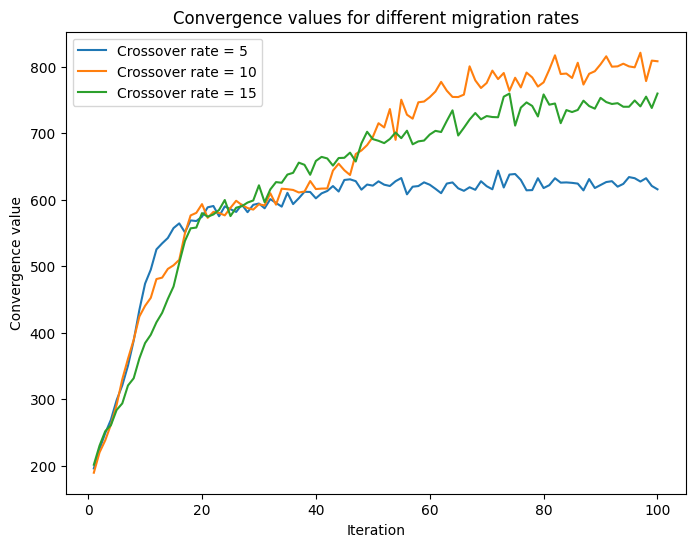

In [8]:
# ring
values = []
migration_rates = [5, 10, 15]

for i in migration_rates:
    ga = IslandGGA(data=train_data,num_islands=8,m_iter=15,num_iter=100,n_migrants=i,pSize=200,r_cross=0.4,r_mut=0.1,strategies=strategies,evolve_strategy="ring")
    ga.evolve()
    values.append(ga.convergence_values)
   
# convergence values for each crossover rate
convergence_values = values
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(migration_rates)):
    plt.plot(np.arange(1, 101), convergence_values[i], label='Crossover rate = ' + str(migration_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different migration rates')
plt.legend()
plt.show()